# How norms shape the evolution of prosocial behavior
### Compassion, Universalizability, Reciprocity, Equity: A C.U.R.E for social dilemmas

This notebook explores a model of decision making under a norm. Each individual has a strategy $x$ and value $v$, then when playing against a player with strategy $y$, chooses the strategy to maximize $$(1-v)p(x,y)+vf(x,y)$$ where $p(x,y)$ is the payoff and $f(x,y)$ is some function specifying the norm being followed. For simplicity, we consider payoffs coming from a single round of a symmetric two player, two action game, with memory zero strategies, which are just the probability of choosing the first action.

More details are available at the bioRxiv preprint https://arxiv.org/abs/2401.13015. 

To explore this, one can vary the game parameters at the online graph https://www.desmos.com/calculator/efrkffhcdb

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math

## Theoretical results
In the compassion case, player's utility is the interpolation of two lines, so is linear, and therefore has maximum at the boundary strategies of pure cooperation, 1, or defection, 0. The transition occurs when they have the same utility, at the value $c_y$ given by $$(1-c_y)p(0,y) + c_yp(y,0) = (1-c_y)p(1,y) + c_yp(1,y)$$ Solving this gives $$c_y = \frac{P-S}{T-S} +  y\frac{\left(T+S-R-P\right)}{T-S} \quad\to\quad c_0 = \frac{P-S}{T-S}, \quad\quad\quad c_1 = \frac{T-R}{T-S}$$

For example, we can plot this for a particular game.  

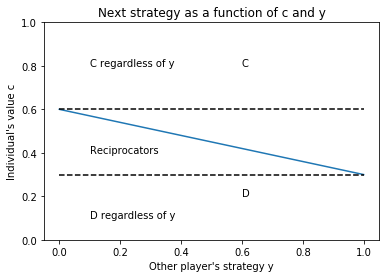

In [2]:
S = 0; P = 0.6; R = 0.7; T = 1;
xs = np.linspace(0,1,100);
ys = (P-S)/(T-S) + xs*(T+S-R-P)/(T-S);

c_0 = (P-S)/(T-S);
c_1 = (T-R)/(T-S);

plt.plot(xs,ys)
plt.xlabel("Other player's strategy y")
plt.ylabel("Individual's value c")
plt.ylim([0,1])
plt.title("Next strategy as a function of c and y")
plt.text(0.6,0.8, "C")
plt.text(0.6,0.2, "D")
plt.plot(xs, [c_0]*100,'k--')
plt.plot(xs, [c_1]*100,'k--')
plt.text(0.1,0.1, "D regardless of y")
plt.text(0.1,0.4, "Reciprocators") # D against D, C against C
plt.text(0.1,0.8, "C regardless of y")

plt.show()

## Code to simulate

In [3]:
def rstp(Game):
    R = Game[0][0]; S = Game[0][1]; T = Game[1][0]; P = Game[1][1]    
    return [R, S, T, P]

def payoff(Game):
    [R, S, T, P] = rstp(Game)    
    return lambda x,y: R*x*y + S*x*(1-y) + T*(1-x)*y + P*(1-x)*(1-y)

def univ_opt(Game, my_val, their_strat):
    v = my_val
    y = their_strat
    p = payoff(Game)
    univ_pay = lambda u,x,y: (1-u)*p(x,y)+u*p(x,x)
    xs = [0, 1]
    
    [R, S, T, P] = rstp(Game)
    if 2*v*(S+T-R-P) == 0:
        crit = 0
    else: 
        crit = (v*(S-2*P+T)+(1-v)*(R*y+S*(1-y)-T*y-P*(1-y)))/(2*v*(S+T-R-P))
    if crit < 1 and crit > 0:
        xs.append(crit)
    
    P = [univ_pay(my_val, x, their_strat) for x in xs]
    max_idx = P.index(max(P))
    
    return xs[max_idx]

def comp_opt(Game, their_strat, my_val):
    p = payoff(Game)
    comp_pay = lambda c,x,y: (1-c)*p(x,y) + c*p(y,x)
    xs = [0, 1]
    
    P = [comp_pay(my_val, x, their_strat) for x in xs]
    max_idx = P.index(max(P))
    
    return xs[max_idx] 




    
    
def fisher_simulation(Game, opt_strat, n_iter, n_pop, strats, vals, p_mut):
    t0 = time.time()
    p = payoff(Game)
    history_strats  = [-1]*n_iter # or a subset of the iterations?
    history_vals    = [-1]*n_iter
    for i in range(0,n_iter):
        history_strats[i] = strats # store strats / vals
        history_vals[i]   = vals
        
        payoffs    = [0]*n_pop
        new_strats = [0]*n_pop
        for j in range(0,n_pop): # Determine fitnesses, 
            other = random.randint(0,n_pop-1)
            y = strats[other]
            v = vals[j]
    
            strat       = opt_strat(Game, y, v) # optimize your action based on their prev. strat.
            strat_other = opt_strat(Game, strats[j], vals[other])
    
            new_strats[j] = strat
            payoffs[j] = p(strat, strat_other)
        
        idxs   = random.choices(range(0,n_pop), payoffs, k=n_pop) # do fisher selection based on payoffs 
        strats = [new_strats[k] for k in idxs]
        vals   = [vals[k] for k in idxs]

        if random.random() < p_mut: # mutate one individual
            mut_idx   = random.randint(0,n_pop-1)
            mut_strat = strats[mut_idx] #min(max(strats(mut_idx)+0.1*random.gauss(),0),1)
            mut_val   = min(max(vals[mut_idx] +0.1*random.gauss(0,1),0),1)
            n_mut = 10 # initial proportion of mutants
            strats[0:n_mut] = n_mut*[mut_strat]
            vals[0:n_mut]   = n_mut*[mut_val]
    print(time.time()-t0)
        
    return [history_strats, history_vals]



def plot_stuff(history_strats, history_vals):
    n_iter = len(history_strats)
    n_pop = len(history_strats[1]);
    avg_strats = [-1]*n_iter
    avg_vals =   [-1]*n_iter
    for i in range(n_iter):
        avg_strats[i] = sum(history_strats[i])/n_pop
        avg_vals[i]   = sum(history_vals[i])/n_pop

    plt.scatter(range(n_iter), avg_strats) # really need to nest, a dist for each entry. 
    plt.ylim([0, 1])
    plt.ylabel("Average strategy")
    plt.xlabel("Iterations")
    plt.show()

    plt.scatter(range(n_iter), avg_vals) # really need to nest, a dist for each entry. 
    plt.ylim([0, 1])
    plt.ylabel("Average value")
    plt.xlabel("Iterations")
    plt.show()

## Generic norms
The below code handles any norm, by precomputing a table of the realized strategies for each value/strategy pair. This is more efficient than recomputing it each time, but introduces some error since the table is discrete, whereas realized strategies are finite. 

The below code makes this table, and plots it. We can see it aligns with the theoretical results above. 

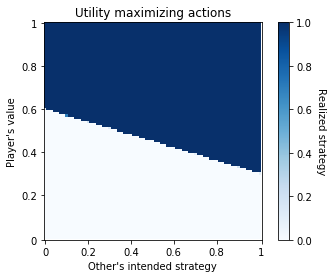

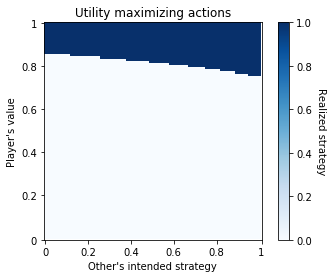

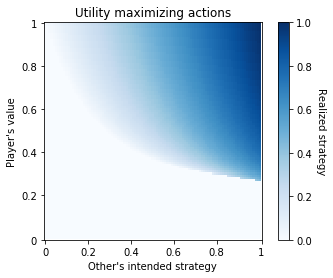

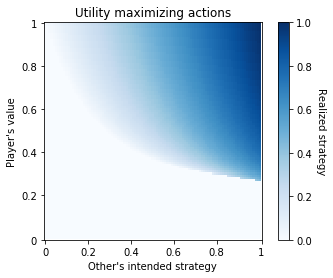

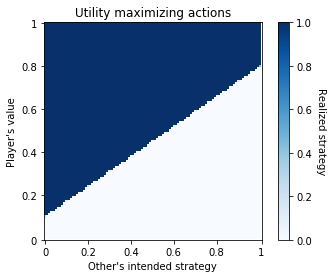

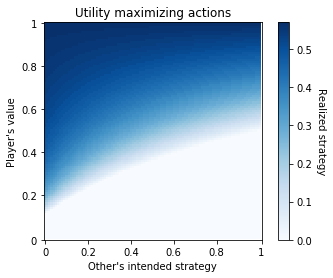

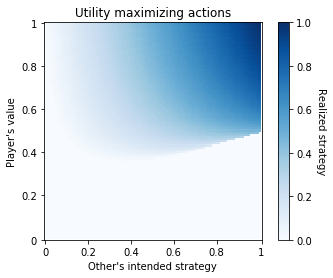

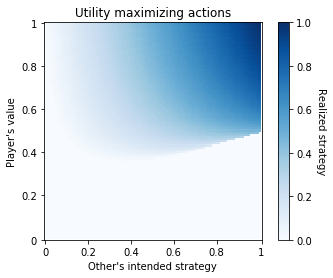

In [4]:
def make_table(grain, Game, norm):
    vals   = np.linspace(0,1,grain)
    strats = np.linspace(0,1,grain)
    optimal_actions = np.zeros([grain, grain])

    pay = payoff(Game)
    utility = lambda v,x,y: (1-v)*pay(x,y) + v*norm(x,y)

    for i in range(grain):
        for j in range(grain):
            P = [utility(vals[i], x, strats[j]) for x in strats]
            idx = P.index(max(P)) # note some value / strat pairs make all strategies equal utility, in which case
            optimal_actions[i][j] = strats[idx] # the optimal value will be zero, or somewhat random due to roundoff error
    return optimal_actions

def plot_realized_strats(Game, norm, grain):
    table  = make_table(grain, Game, norm)
    vals   = np.linspace(0,1,grain)
    strats = np.linspace(0,1,grain)

    flip_table = np.flip(table,0) # since heatplot is weird
    fig, ax = plt.subplots()
    im = ax.imshow(flip_table, cmap = "Blues")

    # Add the color bar
    cbar = ax.figure.colorbar(im, ax = ax)
    cbar.ax.set_ylabel("Realized strategy", rotation = -90, va = "bottom")

    places = [0, 0.2, 0.4, 0.6, 0.8, 1]
    idxs = [math.floor(x*grain) for x in places]
    ax.set_xticks(idxs) # locations of the labels
    ax.set_yticks(idxs)
    ax.set_xticklabels([str(x) for x in places])
    places.reverse()
    ax.set_yticklabels([str(x) for x in places]) # because the table was flipped

    plt.title("Utility maximizing actions")
    plt.xlabel("Other's intended strategy")
    plt.ylabel("Player's value")
    plt.show()
    
def comp(Game):
    pay = payoff(Game)
    return lambda x,y: pay(y,x)

def univ(Game):
    pay = payoff(Game)
    return lambda x,y: pay(x,x)

def reci(Game):
    pay = payoff(Game)
    return lambda x,y: math.exp(-(x-y)**2)

def equi(Game):
    pay = payoff(Game)
    return lambda x,y: math.exp(-(pay(x,y)-pay(y,x))**2)



# the last two will be the same if S-T=1, as some algebra shows pay(x,y)-pay(y,x) = (S-T)(x-y). 

S = 0; P = 0.6; R = 0.7; T = 1;
Game = [[R, S], [T, P]]

for n in [comp, univ, reci, equi]:
    plot_realized_strats(Game, n(Game), 101)
    
    
S = 0; P = 0.1; R = 0.2; T = 1;
Game = [[R, S], [T, P]]

for n in [comp, univ, reci, equi]:
    plot_realized_strats(Game, n(Game), 101)

## General Simulation

2.763627767562866


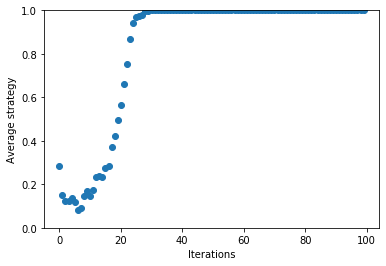

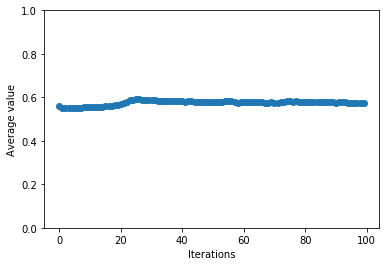

Simulation took 3.4081315994262695 seconds.


In [5]:
def gen_fisher_simulation(Game, table, n_iter, n_pop, strats, vals, p_mut):
    t0 = time.time()
    p = payoff(Game) # uses an outside function
    history_strats  = [-1]*n_iter # or a subset of the iterations?
    history_vals    = [-1]*n_iter
    
    grain = len(table)
    to_ind = lambda x: min(math.ceil(grain*x), grain-1) # convert val/strat, in [0,1], to an index of the table
    
    for i in range(0,n_iter):
        history_strats[i] = strats # store strats / vals
        history_vals[i]   = vals
        
        payoffs    = [0]*n_pop
        new_strats = strats
        for j in range(0,n_pop): # Determine fitnesses, 
            other = random.randint(0,n_pop-1)
            y = strats[other]
            v = vals[j]
    
            #strat       = opt_strat(Game, y, v) # optimize your action based on their prev. strat.
            #strat_other = opt_strat(Game, strats[j], vals[other])
            
            strat       = table[to_ind(v)][to_ind(y)] # optimize your action based on their prev. strat.
            strat_other = table[to_ind(vals[other])][to_ind(strats[j])]
            # since val, strat are in [0, 1], multiplying them gives the approximate position in the array, -1 in case v=1. 
            # or maybe convert the array into a 2d function through interpolation?
    
            new_strats[j] = strat # this line updates strat, so should be removed. 
            payoffs[j] = p(strat, strat_other)
        
        idxs   = random.choices(range(0,n_pop), payoffs, k=n_pop) # do fisher selection based on payoffs 
        strats = [new_strats[k] for k in idxs]
        vals   = [vals[k] for k in idxs]

        if random.random() < p_mut: # mutate one individual
            mut_idx   = random.randint(0,n_pop-1)
            mut_strat = strats[mut_idx] #min(max(strats(mut_idx)+0.1*random.gauss(),0),1)
            mut_val   = min(max(vals[mut_idx] +0.1*random.gauss(0,1),0),1)
            n_mut = 10 # initial proportion of mutants
            strats[0:n_mut] = n_mut*[mut_strat]
            vals[0:n_mut]   = n_mut*[mut_val]
    print(time.time()-t0)
        
    return [history_strats, history_vals]



# Simple use: set population parameters and initial values
n_pop = 1000
n_iter = 100
p_mut = 0

strats = [0]*n_pop
vals = [0.55]*n_pop
p = 0.1
vals[0:math.floor(n_pop*p)] = [0.65]*math.floor(n_pop*p)

S = 0; P = 0.6; R = 0.7; T = 1;
Game = [[R, S], [T, P]]
norm = comp
grain = 101
comp_table = make_table(grain, Game, norm(Game))

start = time.time()
[history_strats, history_vals] = gen_fisher_simulation(Game, comp_table, n_iter, n_pop, strats, vals, p_mut)
plot_stuff(history_strats, history_vals)

print("Simulation took " + str(time.time()-start) + " seconds.")

# This shows the threshold value of c_0 is correct, a small number of invaders with value above this can switch
# a defecting population to pure cooperation. This is subject to some noise given the randomness in this process.

## Including mutation
Now we allow the probability of a value mutation to be nonzero. Indeed we see periods of either pure defection or pure cooperation. We can also see some unsuccessful invasions. 

Note there is not a pure correspondence between the average value crossing the thresholds and these transitions. 

1.123471975326538


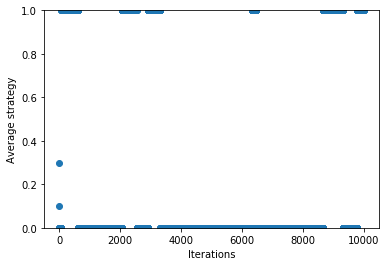

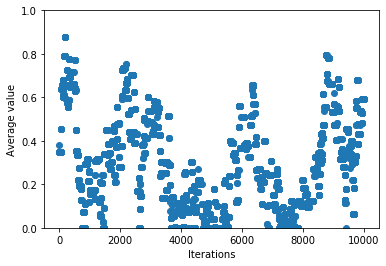

In [6]:
n_pop = 10
n_iter = 10000
p_mut = 0.043

S = 0; P = 0.6; R = 0.7; T = 1;
Game = [[R, S], [T, P]]
grain = 101
norm = comp
comp_table = make_table(grain, Game, norm(Game))

strats = [0]*n_pop
vals = [0.35]*n_pop
p = 0.1
vals[:math.floor(n_pop*p)] = [0.65]*math.floor(n_pop*p)

[history_strats, history_vals] = gen_fisher_simulation(Game, comp_table, n_iter, n_pop, strats, vals, p_mut)
plot_stuff(history_strats, history_vals)

The mutation rate needs to be small to allow fixation before the next mutant emerges. The paper "How small are small mutation rates?" by Wu et al, 2012 J. Math Bio says for most games mutation should be around $1/N\ln(N)$. For reference, this is 0.043 for $N=10$, 0.0021 for $N=100$, and 0.00014 for $N=1000$. 

## Different games - Stag Hunt

0.17253851890563965


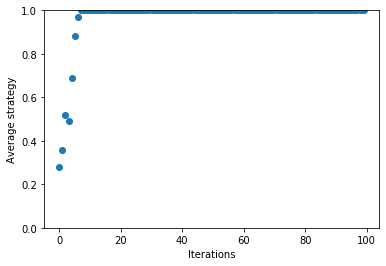

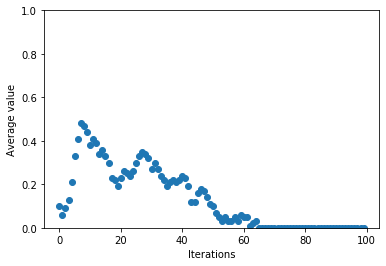

In [7]:
# Compassion can allow agents to find the optimal coordinated equilibrium. 

n_pop = 100
n_iter = 100 #5000
p_mut = 0.01

Game = [[4, 1], [3, 2]]
grain = 101
comp_table = make_table(grain, Game, norm(Game))

strats = [0]*n_pop
vals = [0]*n_pop
p = 0.1
vals[:math.floor(n_pop*p)] = [1]*math.floor(n_pop*p)

[history_strats, history_vals] = gen_fisher_simulation(Game, comp_table, n_iter, n_pop, strats, vals, p_mut)
plot_stuff(history_strats, history_vals)

## Run longer
To determine what portion of the time the population spends cooperating overall, the simulation must be run for a long period. 

Each run only keeps the time average of the population's average strat/val, then the final distribution is used as initial distribution of the next simulation, that way only the data from one run must be kept. 

5.581504821777344
5.137011528015137
6.281962871551514
5.285822629928589
5.291043996810913
5.485154390335083
5.250610828399658
5.655010223388672
5.8250486850738525
7.136643171310425
5.336641311645508
5.524166584014893
5.519212961196899
5.311227321624756
5.826626300811768
5.403398275375366
5.546939373016357
5.618685722351074
5.503068685531616
6.900510787963867


Took 114.5722017288208 seconds. 
Average strategy was 0.623773738


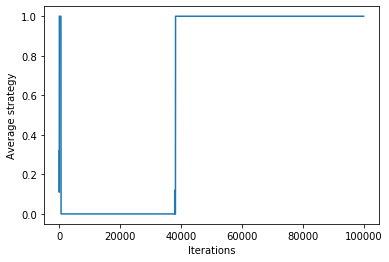

In [8]:
n_pop = 100
n_iter = 5000
p_mut = 0.01

S = 0; P = 0.6; R = 0.7; T = 1;
Game = [[R, S], [T, P]]
grain = 101
comp_table = make_table(grain, Game, norm(Game))

strats = [0]*n_pop
vals = [0.55]*n_pop
p = 0.1
vals[:math.floor(n_pop*p)] = [0.65]*math.floor(n_pop*p)

n_runs = 20

avg_avg_vals = [-1]*n_runs
avg_avg_strats = [-1]*n_runs
long_avg_strats = []
start = time.time()
for i in range(0,n_runs):
    [history_strats, history_vals] = gen_fisher_simulation(Game, comp_table, n_iter, n_pop, strats, vals, p_mut)
    
    strats = history_strats[n_iter-1] # set the new initial distribution to the final of the previous run
    vals = history_vals[n_iter-1] 
    
    avg_strats = [sum(history_strats[i])/n_pop for i in range(0,n_iter)]
    avg_vals   = [sum(history_vals[i])/n_pop   for i in range(0,n_iter)]
    
    avg_avg_strats[i]   = sum(avg_strats)/n_iter
    avg_avg_vals[i]     = sum(avg_vals)/n_iter
    
    long_avg_strats = long_avg_strats + avg_strats

print("\n\nTook " + str(time.time()-start) + " seconds. ")

print("Average strategy was " + str(sum(avg_avg_strats)/n_runs)) # how to put an error on this? I guess as you run 
# the process longer, the average will stabilize, but this would be just by the properties of the average

plt.plot(range(0,n_iter*n_runs), long_avg_strats)
plt.xlabel("Iterations")
plt.ylabel("Average strategy")
plt.show()

## Other norms

Here we show that Universalizability can result in cooperation, indeed it is more effective at promoting this. However, reciprocity and equity cannot, since there is no incentive to be more cooperative than the other player. Note this was not obvious, as other studies have shown reciprocity being a significant force, for example Tit-for-tat is a strategy in the iterated Prisoner's Dilemma based on this idea, and performs incredibly well. It is possible that there would be a similar buffer effect as in the other norms, where some individuals cooperate with cooperators and defect against defectors. This turned out to be insufficient though. 

5.806634187698364


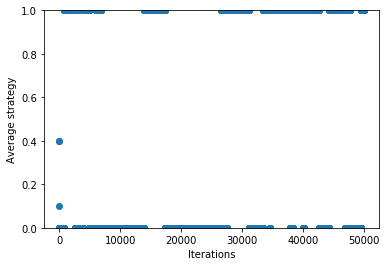

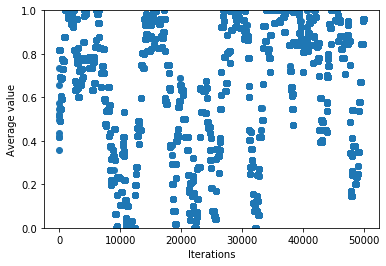

57.079713344573975


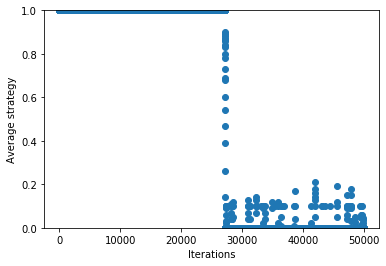

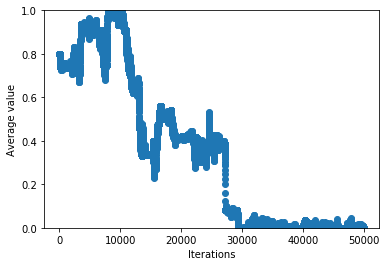

1.1349248886108398


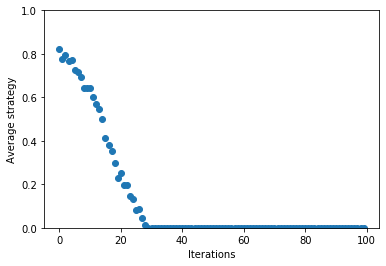

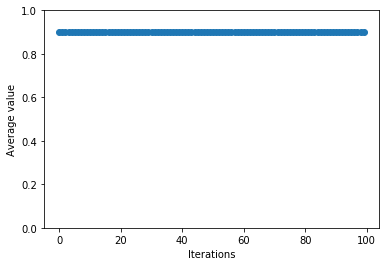

In [9]:
# Universalizability:

n_pop = 10
n_iter = 50000
p_mut = 0.01

S = 0; P = 0.6; R = 0.7; T = 1;
Game = [[R, S], [T, P]]
grain = 101
univ_table = make_table(grain, Game, univ(Game))

strats = [0]*n_pop
vals = [random.random() for i in range(n_pop)]

[history_strats, history_vals] = gen_fisher_simulation(Game, univ_table, n_iter, n_pop, strats, vals, p_mut)
plot_stuff(history_strats, history_vals)



# Larger n_pop, different game

n_pop = 100

S = 0; P = 0.09; R = 0.9; T = 1;
Game = [[R, S], [T, P]]
univ_table = make_table(grain, Game, univ(Game))

strats = [0]*n_pop
p = 0.9
strats[:math.floor(n_pop*p)] = [1]*math.floor(n_pop*p)
vals = [0.8 for i in range(n_pop)]

[history_strats, history_vals] = gen_fisher_simulation(Game, univ_table, n_iter, n_pop, strats, vals, p_mut)
plot_stuff(history_strats, history_vals)





# Reciprocity:

n_pop = 1000
n_iter = 100
p_mut = 0

S = 0; P = 0.5; R = 4.95; T = 5;
Game = [[R, S], [T, P]]
grain = 101
reci_table = make_table(grain, Game, reci(Game))

#strats = [random.random() for i in range(n_pop)] # [0]*n_pop
#vals = [random.random() for i in range(n_pop)]

# Random on both doesn't lead to cooperation. 

strats = [0]*n_pop
p = 0.9
strats[:math.floor(n_pop*p)] = [1]*math.floor(n_pop*p)
vals = [0.9]*n_pop

[history_strats, history_vals] = gen_fisher_simulation(Game, reci_table, n_iter, n_pop, strats, vals, p_mut)
plot_stuff(history_strats, history_vals)





# Equity: Pointless to test, since it is the same as reci if T-S=1. 

## Large n limit

Here we look at a large enough population where pairs occurs with the product of frequencies of each member. This makes the process deterministic, governed by the updates:

$$\begin{align*}
    C' &= (R(C+I_C+I_D)+S D)C \\
    I_C' &= R ((I_C+I_D) C+I_C I_C)+S I_D I_C\\ % (who they were before)(who they interacted with, must play the action matching the left-hand-side)
    I_D' &= P ((I_C+I_D) D+I_D I_D)+T I_C I_D \\
    D' &= (T C+P (I_C+I_D+D)) D
\end{align*}$$

The convension for ordering terms is the player's type, then that of the other player. 

Technically this is not an ODE, thought you could relate it to the replicator equations, possibly with mutation, as these would be the changes in a small time step. Therefore in the following plots we rescale after every application of this update. 

In [10]:
def large_pop_limit_before(n_iter, C0, I_C0, I_D0, D0, game):
    [R, S, T, P] = rstp(game)
    
    Cs   = [0]*n_iter;
    I_Cs = [0]*n_iter;
    I_Ds = [0]*n_iter;
    Ds   = [0]*n_iter;

    Cs[0]   = C0;
    I_Cs[0] = I_C0; 
    I_Ds[0] = I_D0; 
    Ds[0]   = D0;
    
    # scale to sum to 1. 
    total = Cs[0]+I_Cs[0]+I_Ds[0]+Ds[0];
    Cs[0] = Cs[0]/total; I_Cs[0] = I_Cs[0]/total; I_Ds[0] = I_Ds[0]/total; Ds[0] = Ds[0]/total; 
        
    for i in range(1, n_iter):
        C   = Cs[i-1]; # Get old values
        I_C = I_Cs[i-1];
        I_D = I_Ds[i-1];
        D   = Ds[i-1];
    
        Cs[i]   = (R*(C+I_C+I_D)+S*D)*C; # Make new ones
        I_Cs[i] = R*((I_C+I_D)*C+I_C*I_C)+S*I_D*I_C; # I was / I saw order
        I_Ds[i] = P*((I_C+I_D)*D+I_D*I_D)+T*I_C*I_D;
        Ds[i]   = (T*C+P*(I_C+I_D+D))*D;
        
        # Renormalize
        total = Cs[i]+I_Cs[i]+I_Ds[i]+Ds[i]; # What do these looks like?
        Cs[i]   = Cs[i]/total;
        I_Cs[i] = I_Cs[i]/total;
        I_Ds[i] = I_Ds[i]/total;
        Ds[i]   = Ds[i]/total;
    return [Cs, I_Cs, I_Ds, Ds]

def plot_large_n_history(xlab, ylab, title, xs, Cs, I_Cs, I_Ds, Ds, colors):
    n_iter = len(Cs);
    plt.plot(xs, Cs, colors[0])
    plt.plot(xs, I_Cs, colors[1])
    plt.plot(xs, I_Ds, colors[2])
    plt.plot(xs, Ds, colors[3])
    plt.legend(["Cs", "R_Cs", "R_Ds", "Ds"])
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.show()

## In a favorable game, reciprocating players allow cooperators to invade, and prevent defectors from invading

Note the cooperators may be unseen, underneath another line. 

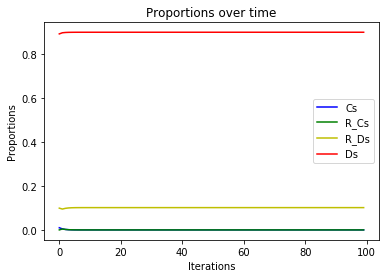

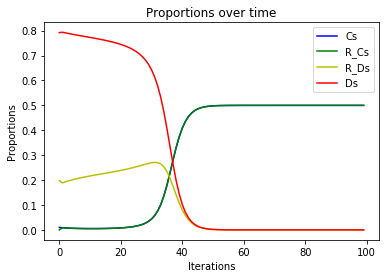

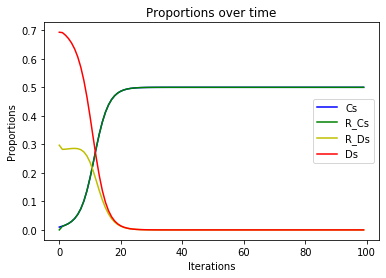

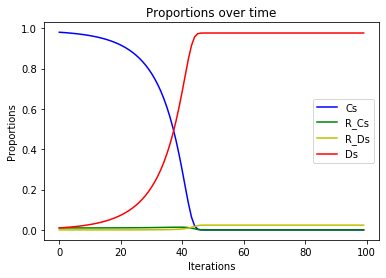

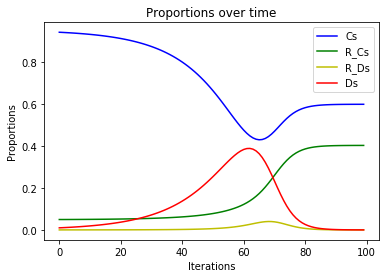

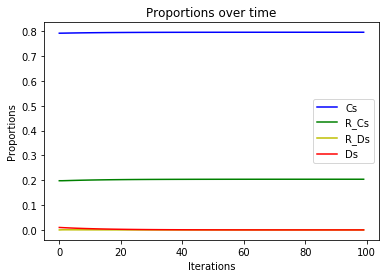

In [11]:
S = 0; P = 0.2; R = 0.9; T = 1; # P is low, so mutual defection results in a bad payoff, but R is high, so mutual 
game = [[R, S], [T, P]] # cooperation is rewarded. 
n_iter = 100
epsilon = 0.01

xlab = "Iterations"
ylab = "Proportions"
title = "Proportions over time"
xs = range(n_iter)
colors = ['b', 'g', 'y', 'r']

r = 0.1
[Cs, I_Cs, I_Ds, Ds] = large_pop_limit_before(n_iter, epsilon, 0, r, 1-r, game)
plot_large_n_history(xlab, ylab, title, xs, Cs, I_Cs, I_Ds, Ds, colors)

r = 0.2
[Cs, I_Cs, I_Ds, Ds] = large_pop_limit_before(n_iter, epsilon, 0, r, 1-r, game)
plot_large_n_history(xlab, ylab, title, xs, Cs, I_Cs, I_Ds, Ds, colors)

r = 0.3
[Cs, I_Cs, I_Ds, Ds] = large_pop_limit_before(n_iter, epsilon, 0, r, 1-r, game)
plot_large_n_history(xlab, ylab, title, xs, Cs, I_Cs, I_Ds, Ds, colors)







print("\n\n\n\n")

r = 0.01
[Cs, I_Cs, I_Ds, Ds] = large_pop_limit_before(n_iter, 1-r, r, 0, epsilon, game)
plot_large_n_history(xlab, ylab, title, xs, Cs, I_Cs, I_Ds, Ds, colors)

r = 0.05
[Cs, I_Cs, I_Ds, Ds] = large_pop_limit_before(n_iter, 1-r, r, 0, epsilon, game)
plot_large_n_history(xlab, ylab, title, xs, Cs, I_Cs, I_Ds, Ds, colors)

r = 0.2
[Cs, I_Cs, I_Ds, Ds] = large_pop_limit_before(n_iter, 1-r, r, 0, epsilon, game)
plot_large_n_history(xlab, ylab, title, xs, Cs, I_Cs, I_Ds, Ds, colors)

## Making a heatmap of these thresholds over S,T-space
Using the argmin of the differences in the final numbers of defectors, when this drops a large amount (to zero) defectors weren't able to invade, or were invaded by cooperators. Note we don't use the first time defectors end at zero, as they might not be, even if they are close. 

Simulation took 64.57679486274719 seconds


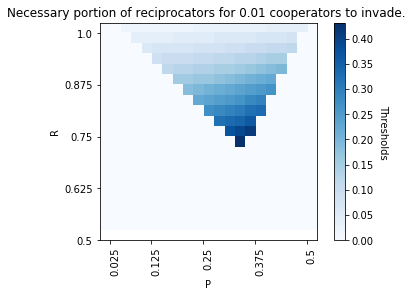

In [12]:
S = 0; T = 1;

n_iter = 500
epsilon = 0.01

n_rs = 101
rs = np.linspace(0.01,0.99,n_rs)

grid_size = 20
Ps = 0+np.asarray(range(1,grid_size+1))/grid_size/2
Rs = 0.5+np.asarray(range(grid_size+1))/grid_size/2

thresholds = 0*np.ones([len(Ps), len(Rs)])
start = time.time()
for i in range(len(Ps)):
    for j in range(len(Rs)):
        if Ps[i] < Rs[j] and Rs[j] < 1-Ps[i]: # game is a PD, and this model applies
            game = [[Rs[j], S], [T, Ps[i]]]

            end_Cs = [-1]*n_rs; end_I_Cs = [-1]*n_rs; end_I_Ds = [-1]*n_rs; end_Ds = [-1]*n_rs; 
            for k in range(n_rs):
                r = rs[k]
                [Cs, I_Cs, I_Ds, Ds] = large_pop_limit_before(n_iter, epsilon, 0, r, 1-r, game)
                end_Cs[k] = Cs[n_iter-1]
                end_I_Cs[k] = I_Cs[n_iter-1]
                end_I_Ds[k] = I_Ds[n_iter-1]
                end_Ds[k] = Ds[n_iter-1]

            diff_Ds = [end_Ds[i+1]-end_Ds[i] for i in range(len(end_Ds)-1)]
            max_drop_location = np.argmin(diff_Ds)+1
            
            if end_Ds[max_drop_location] < 0.001:
                thresholds[i][j] = rs[max_drop_location] # gives the biggest drop in the number of defectors,
            else: # may only get very close to 0
                thresholds[i][j] = 0 # or 2 or something to indicate impossibility
            
            
            if i in [] and j in []: # 3, 6, 9, 12, 15, 18
                print("P = " + str(Ps[i]) + ", R = " + str(Rs[j]))
                
                print(max_drop_location)
                print(end_Ds[max_drop_location])
                
                plot_large_n_history("varying proportion of reciprocators", "ending proportions", 
                                     "Proportions at t = " + str(n_iter), rs, end_Cs, end_I_Cs, end_I_Ds, end_Ds)
                print()
        
print("Simulation took " + str(time.time()-start) + " seconds")





# Do a heatplot over the PR space. 
flip_thresholds = np.flip(thresholds,1) # since heatplot is weird
fig, ax = plt.subplots()
im = ax.imshow(flip_thresholds, cmap = "Blues")

# Add the color bar
cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Thresholds", rotation = -90, va = "bottom")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

plt.title("Necessary portion of reciprocators for " + str(epsilon) + " cooperators to invade. ")
plt.xlabel("P")
plt.ylabel("R")

#L = [0, 8, 16, 24, 32, 40, 48]
Lx = [0, 4, 9, 14, 19]
Ly = [0, 5, 10, 15, 20]
plt.xticks(np.array(Lx) + 0.5)
plt.yticks(np.array(Ly) + 0.5)
#plt.xticks(np.array([0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]) + 0.5)
#plt.yticks(np.array([0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]) + 0.5)

ax.set_xticklabels([str(Ps[x]) for x in Lx])
string_Rs = [str(Rs[x]) for x in Ly]
string_Rs.reverse()
ax.set_yticklabels(string_Rs)

plt.show() 


## Interactive Plots of the large n limit starting with various levels of imitators and a small fraction of invaders

Here the user can manually edit the game parameters:

    P is the payoff for mutual defection, make this lower to favor cooperation. 

    R is the payoff for mutual cooperation, make this higher to favor cooperation. 

    r is the initial fraction of imitators, make this higher to favor imitators. 

Play around with these parameters to see what values are needed to prevent an invasion of defectors!

You can click a new point on the slider, or drag it to get a sort of animation, or click in the number next to the slider to enter a new value. 

In [13]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(P,R, r):
    if R < P:
        print("Not a prisoner's dilemma!")
    game = [[R, 0], [1, P]] 
    n_iter = 100
    epsilon = 0.01
    
    xlab = "Iterations"
    ylab = "Proportions"
    xs = range(n_iter)
    
    print("The predicted number of imitators necessary for defectors to invade is at least " + str((R-T)/(P-T)))
    [Cs, I_Cs, I_Ds, Ds] = large_pop_limit_before(n_iter, 1-r, r, 0, epsilon, game)
    title = "Proportions over time, starting with " + str(epsilon) + " defectors and " + str(r) + " reciprocators"
    plot_large_n_history(xlab, ylab, title, xs, Cs, I_Cs, I_Ds, Ds, colors)
    
    print("The predicted number of imitators necessary for cooperators to invade is at least " + str((P-S)/(R-S)))    
    [Cs, I_Cs, I_Ds, Ds] = large_pop_limit_before(n_iter, epsilon, 0, r, 1-r, game)
    title = "Proportions over time, starting with " + str(epsilon) + " cooperators and " + str(r) + " reciprocators"
    plot_large_n_history(xlab, ylab, title, xs, Cs, I_Cs, I_Ds, Ds, colors)

interact(f, P=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.25),
        R=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5),
        r=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.75))

# or interact_manual with same params so the things doesn't reevaluate until you tell it

interactive(children=(FloatSlider(value=0.25, description='P', max=1.0, step=0.01), FloatSlider(value=0.5, des…

<function __main__.f(P, R, r)>

## Monomorphic populations
A simple analysis of the Moran process takes the low mutation limit, where it suffices to investigate the fixation probability of a mutant invading a monomorphic population. The principle eigenvector of the transition matrix between these monomorphic states gives the proportion of time the population will spend in each. 

In [14]:
def classic_fixation(game, n, w): # returns the fixation probability of the first action invading the second
    [a, b, c, d] = rstp(game)
    # really game gives the payoffs received where the first row/col is the invader, the second is the resident
    # so can pass in the games with rows / columns swapped to calculate the reverse. 
    total = 0
    for k in [x+1 for x in range(n-1)]:
        prod = 1
        for i in [x+1 for x in range(k)]:
            #prod = prod * (1-w+w* (c*i+d*(n-i-1))/(n-1) ) / ( 1-w+w* (a*(i-1)+b*(n-1)) / (n-1) )
            prod = prod * (math.exp(w* (c*i+d*(n-i-1))/(n-1) ) / (math.exp(w* (a*(i-1)+b*(n-1)) / (n-1) )) )
        total = total + prod
    return 1/(1+total)
                           
#print(classic_fixation([[20, 0], [17, 1]], 10, 0.99))
#print(classic_fixation([[1, 17], [0, 20]], 10, 0.99))

#print(classic_fixation([[20, 0], [17, 1]], 10, 0))
#print(classic_fixation([[1, 17], [0, 20]], 10, 0))
# will get division by zero if b is zero, and w=1.



def find_eig(n,w,S,P,R,T):
    p_C_invades_IC = 1/n # neutral selection
    p_C_invades_ID = classic_fixation([[R, R], [R, P]], n, w)
    p_C_invades_D  = classic_fixation([[R, S], [T, P]], n, w)
    p_C_invades_C  = 1-(p_C_invades_IC+p_C_invades_ID+p_C_invades_D)

    p_IC_invades_C  = 1/n # neutral
    p_IC_invades_ID = classic_fixation([[R, T], [S, P]], n, w)
    p_IC_invades_D  = classic_fixation([[R, P], [P, P]], n, w)
    p_IC_invades_IC = 1-(p_IC_invades_C+p_IC_invades_ID+p_IC_invades_D)

    p_ID_invades_C  = classic_fixation([[P, R], [R, R]], n, w)
    p_ID_invades_IC = classic_fixation([[P, S], [T, R]], n, w)
    p_ID_invades_D  = 1/n
    p_ID_invades_ID = 1-(p_ID_invades_C+p_ID_invades_IC+p_ID_invades_D)

    p_D_invades_C  = classic_fixation([[P, T], [S, R]], n, w)
    p_D_invades_IC = classic_fixation([[P, P], [P, R]], n, w)
    p_D_invades_ID = 1/n
    p_D_invades_D  = 1-(p_D_invades_C+p_D_invades_IC+p_D_invades_ID)


    M = np.matrix([[p_C_invades_C,  p_C_invades_IC,  p_C_invades_ID,  p_C_invades_D ],
                   [p_IC_invades_C, p_IC_invades_IC, p_IC_invades_ID, p_IC_invades_D], 
                   [p_ID_invades_C, p_ID_invades_IC, p_ID_invades_ID, p_ID_invades_D], 
                   [p_D_invades_C,  p_D_invades_IC,  p_D_invades_ID,  p_D_invades_D ]])

    [W, V] = np.linalg.eig(M)
    i = np.argmax(W)
    princ_eig = V[i]

    [W, V] = np.linalg.eig(np.transpose(M))
    i = np.argmax(W)
    princ_eig = np.transpose(V)[i] # to get ith column of V
    
    return princ_eig

## Varying selection strength
As expected, $w=0$ corresponds to neutral selection. 

Surprisingly the curves aren't all monotonic with $w$, for example when (S,P,R,T) = (0,0.1,0.2,1).

Also, the curve look different for different $n$, which is to be expected, since this affects the stochasticity. Intuitively, increasing $n$ looks like allowing for selection strength above 1, since randomness is suppressed further. 

C:\anaconda\lib\site-packages\ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


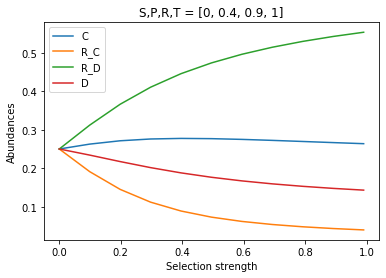

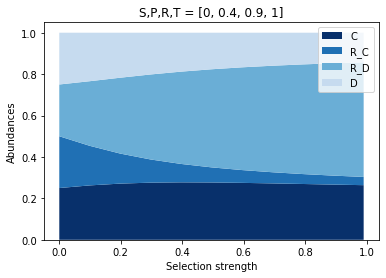

In [15]:
n = 10
#S = 0; P = 0.05; R = 0.99; T = 1; # D actually above C
#S = 0; P = 0.2; R = 0.9; T = 1; # C lower with high w!
S = 0; P = 0.4; R = 0.9; T = 1; # C lower with high w!
#S = 0; P = 0.5; R = 0.6; T = 1;
#S = 0; P = 0.8; R = 0.9; T = 1; 

ws = np.linspace(0,0.99,11)
final_props = -1*np.ones([len(ws),4])
for i in range(len(ws)):
    vec = find_eig(n,ws[i],S,P,R,T)
    if np.sum(np.imag(vec)) != 0:
        print("Nonzero imaginary part of principal eigenvector in i = " + str(i))
    final_props[i,:] = vec/np.sum(vec) # warning about losing imaginary part
    
plt.plot(ws, final_props[:,0])
plt.plot(ws, final_props[:,1])
plt.plot(ws, final_props[:,2])
plt.plot(ws, final_props[:,3])
plt.legend(["C", "R_C", "R_D", "D"])
plt.xlabel("Selection strength")
plt.ylabel("Abundances")
plt.title("S,P,R,T = " + str([S,P,R,T]))
plt.show()

c = ['lightsteelblue', 'cornflowerblue', 'steelblue', 'royalblue']

import matplotlib as mpl
c = np.arange(1, 5 + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])
colors = [cmap.to_rgba(i + 1) for i in range(5)]
colors.reverse()
#print(colors)

plt.stackplot(ws, [final_props[:,0], final_props[:,1], final_props[:,2], final_props[:,3]], colors=colors[:-1])
plt.legend(["C", "R_C", "R_D", "D"])
plt.xlabel("Selection strength")
plt.ylabel("Abundances")
plt.title("S,P,R,T = " + str([S,P,R,T]))
plt.show()

# Heatmap of time in cooperating state over all possible games. 

C:\anaconda\lib\site-packages\ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


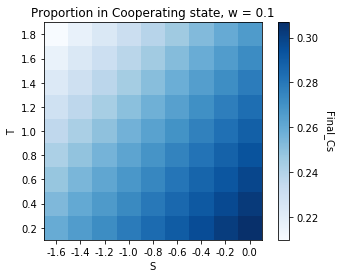

In [16]:
n = 10
P = 0; R = 1;
w = 0.1

Ss = [-x/5 for x in range(0,9)]
Ts = [x/5 for x in range(1,10)]
final_Cs = -1*np.ones([len(Ss),len(Ts)])
for i in range(len(Ss)):
    for j in range(len(Ts)):
        vec = find_eig(n,w,Ss[i],P,R,Ts[j])
        if np.sum(np.imag(vec)) != 0:
            print("Nonzero imaginary part of principal eigenvector in i = " + str(i))
        normalized = vec/np.sum(vec)
        final_Cs[i,j] = normalized[0,0] # warning about losing imaginary part
        
fig, ax = plt.subplots()
im = ax.imshow(final_Cs, cmap = "Blues")

# Add the color bar
cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Final_Cs", rotation = -90, va = "bottom")

xlabs = [str(x) for x in Ss]
xlabs.reverse()
ylabs = [str(x) for x in Ts]
ylabs.reverse()
ax.set_xticks(np.arange(len(Ss)))
ax.set_yticks(np.arange(len(Ts)))
ax.set_xticklabels(xlabs)
ax.set_yticklabels(ylabs)

plt.title("Proportion in Cooperating state, w = " + str(w))
plt.xlabel("S")
plt.ylabel("T")
plt.show() 

## Conditions on the payoffs for each type to be favored. 

In [17]:
import sympy as sp

R, S, T, P = sp.symbols('R S T P')

#     C, I_C, I_D, D
M = [[R,   R,   R, S], # C
     [R,   R,   T, P], # I_C
     [R,   S,   P, P], # I_D
     [T,   P,   P, P], # D
    ]

def low_mut_conds(M):
    n = len(M)
    L = [-1]*n
    for k in range(n):
        S = 0
        for i in range(n):
            S = S + M[k][k]+M[k][i]-M[i][k]-M[i][i]
        L[k] = S#/n
    return L

def high_mut_conds(M):
    n = len(M)
    H = [-1]*n
    for k in range(n):
        S = 0
        for i in range(n):
            for j in range(n):
                S = S + M[k][j]-M[i][j]
        H[k] = S#/(n**2)
    return H

L = low_mut_conds(M)
H = high_mut_conds(M)

print(L)
print(H)

[-2*P + 2*R + S - T, -2*P + 2*R - S + T, 2*P - 2*R + S - T, 2*P - 2*R - S + T]
[-6*P + 6*R + 2*S - 2*T, -2*P + 2*R - 2*S + 2*T, 2*P - 2*R + 2*S - 2*T, 6*P - 6*R - 2*S + 2*T]
